This Notebook illustrates the use of the openmc.mgxs.Library class specifically for application in OpenMC's multi-group mode. This example notebook follows the same process as was done in MGXS Part III, but instead uses OpenMC as the multi-group solver. This Notebook illustrates the following features:

    Calculation of multi-group cross sections for a fuel assembly
    Automated creation, manipulation and storage of MGXS with openmc.mgxs.Library
    Validation of multi-group cross sections with OpenMC
    Steady-state pin-by-pin fission rates comparison between Continuous-Energy mode and Multi-Group OpenMC.

Note: This Notebook illustrates the use of Pandas DataFrames to containerize multi-group cross section data. We recommend using Pandas >v0.15.0 or later since OpenMC's Python API leverages the multi-indexing feature included in the most recent releases of Pandas.


# Generate Input Files

In [1]:
import math
import pickle

from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import os

import openmc
import openmc.mgxs

%matplotlib inline


First we need to define materials that will be used in the problem. Before defining a material, we must create nuclides that are used in the material.

In [2]:
# Instantiate some Nuclides
h1 = openmc.Nuclide('H-1')
b10 = openmc.Nuclide('B-10')
o16 = openmc.Nuclide('O-16')
u235 = openmc.Nuclide('U-235')
u238 = openmc.Nuclide('U-238')
zr90 = openmc.Nuclide('Zr-90')

With the nuclides we defined, we will now create three materials for the fuel, water, and cladding of the fuel pins.

In [3]:
# 1.6 enriched fuel
fuel = openmc.Material(name='1.6% Fuel')
fuel.set_density('g/cm3', 10.31341)
fuel.add_nuclide(u235, 3.7503e-4)
fuel.add_nuclide(u238, 2.2625e-2)
fuel.add_nuclide(o16, 4.6007e-2)

# borated water
water = openmc.Material(name='Borated Water')
water.set_density('g/cm3', 0.740582)
water.add_nuclide(h1, 4.9457e-2)
water.add_nuclide(o16, 2.4732e-2)
water.add_nuclide(b10, 8.0042e-6)

# zircaloy
zircaloy = openmc.Material(name='Zircaloy')
zircaloy.set_density('g/cm3', 6.55)
zircaloy.add_nuclide(zr90, 7.2758e-3)

With our three materials, we can now create a Materials object that can be exported to an actual XML file.

In [4]:
# Instantiate a Materials object
materials_file = openmc.Materials((fuel, water, zircaloy))
materials_file.default_xs = '71c'

# Export to "materials.xml"
materials_file.export_to_xml()

Now let's move on to the geometry. This problem will be a square array of fuel pins and control rod guide tubes for which we can use OpenMC's lattice/universe feature. The basic universe will have three regions for the fuel, the clad, and the surrounding coolant. The first step is to create the bounding surfaces for fuel and clad, as well as the outer bounding surfaces of the problem.

In [5]:
# Create cylinders for the fuel and clad
fuel_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.39218)
clad_outer_radius = openmc.ZCylinder(x0=0.0, y0=0.0, R=0.45720)

# Create boundary planes to surround the geometry
min_x = openmc.XPlane(x0=-10.71, boundary_type='reflective')
max_x = openmc.XPlane(x0=+10.71, boundary_type='reflective')
min_y = openmc.YPlane(y0=-10.71, boundary_type='reflective')
max_y = openmc.YPlane(y0=+10.71, boundary_type='reflective')
min_z = openmc.ZPlane(z0=-10., boundary_type='reflective')
max_z = openmc.ZPlane(z0=+10., boundary_type='reflective')

With the surfaces defined, we can now construct a fuel pin cell from cells that are defined by intersections of half-spaces created by the surfaces.

In [6]:
# Create a Universe to encapsulate a fuel pin
fuel_pin_universe = openmc.Universe(name='1.6% Fuel Pin')

# Create fuel Cell
fuel_cell = openmc.Cell(name='1.6% Fuel')
fuel_cell.fill = fuel
fuel_cell.region = -fuel_outer_radius
fuel_pin_universe.add_cell(fuel_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='1.6% Clad')
clad_cell.fill = zircaloy
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
fuel_pin_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='1.6% Moderator')
moderator_cell.fill = water
moderator_cell.region = +clad_outer_radius
fuel_pin_universe.add_cell(moderator_cell)

Likewise, we can construct a control rod guide tube with the same surfaces.

In [7]:
# Create a Universe to encapsulate a control rod guide tube
guide_tube_universe = openmc.Universe(name='Guide Tube')

# Create guide tube Cell
guide_tube_cell = openmc.Cell(name='Guide Tube Water')
guide_tube_cell.fill = water
guide_tube_cell.region = -fuel_outer_radius
guide_tube_universe.add_cell(guide_tube_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='Guide Clad')
clad_cell.fill = zircaloy
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
guide_tube_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='Guide Tube Moderator')
moderator_cell.fill = water
moderator_cell.region = +clad_outer_radius
guide_tube_universe.add_cell(moderator_cell)

Using the pin cell universe, we can construct a 17x17 rectangular lattice with a 1.26 cm pitch.

In [8]:
# Create fuel assembly Lattice
assembly = openmc.RectLattice(name='1.6% Fuel Assembly')
assembly.dimension = (17, 17)
assembly.pitch = (1.26, 1.26)
assembly.lower_left = [-1.26 * 17. / 2.0] * 2

Next, we create a NumPy array of fuel pin and guide tube universes for the lattice.

In [9]:
# Create array indices for guide tube locations in lattice
template_x = np.array([5, 8, 11, 3, 13, 2, 5, 8, 11, 14, 2, 5, 8,
                       11, 14, 2, 5, 8, 11, 14, 3, 13, 5, 8, 11])
template_y = np.array([2, 2, 2, 3, 3, 5, 5, 5, 5, 5, 8, 8, 8, 8,
                       8, 11, 11, 11, 11, 11, 13, 13, 14, 14, 14])

# Initialize an empty 17x17 array of the lattice universes
universes = np.empty((17, 17), dtype=openmc.Universe)

# Fill the array with the fuel pin and guide tube universes
universes[:,:] = fuel_pin_universe
universes[template_x, template_y] = guide_tube_universe

# Store the array of universes in the lattice
assembly.universes = universes

OpenMC requires that there is a "root" universe. Let us create a root cell that is filled by the pin cell universe and then assign it to the root universe.

In [10]:
# Create root Cell
root_cell = openmc.Cell(name='root cell')
root_cell.fill = assembly

# Add boundary planes
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

# Create root Universe
root_universe = openmc.Universe(universe_id=0, name='root universe')
root_universe.add_cell(root_cell)

We now must create a geometry that is assigned a root universe and export it to XML.

In [11]:
# Create Geometry and set root Universe
geometry = openmc.Geometry()
geometry.root_universe = root_universe
# Export to "geometry.xml"
geometry.export_to_xml()

With the geometry and materials finished, we now just need to define simulation parameters. In this case, we will use 10 inactive batches and 40 active batches each with 2500 particles.

In [12]:
# OpenMC simulation parameters
batches = 200
inactive = 10
particles = 5000

# Instantiate a Settings object
settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles
settings_file.output = {'tallies': False}

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [-10.71, -10.71, -10, 10.71, 10.71, 10.]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:], only_fissionable=True)
settings_file.source = openmc.source.Source(space=uniform_dist)

# Export to "settings.xml"
settings_file.export_to_xml()

Let us also create a Plots file that we can use to verify that our fuel assembly geometry was created successfully.

In [13]:
# Instantiate a Plot
plot = openmc.Plot(plot_id=1)
plot.filename = 'materials-xy'
plot.origin = [0, 0, 0]
plot.pixels = [250, 250]
plot.width = [-10.71*2, -10.71*2]
plot.color = 'mat'

# Instantiate a Plots object, add Plot, and export to "plots.xml"
plot_file = openmc.Plots([plot])
plot_file.export_to_xml()

With the plots.xml file, we can now generate and view the plot. OpenMC outputs plots in .ppm format, which can be converted into a compressed format like .png with the convert utility.

In [14]:
# Run openmc in plotting mode
openmc.plot_geometry(output=False)

0

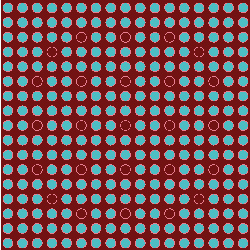

In [15]:
# Convert OpenMC's funky ppm to png
!convert materials-xy.ppm materials-xy.png

# Display the materials plot inline
Image(filename='materials-xy.png')

As we can see from the plot, we have a nice array of fuel and guide tube pin cells with fuel, cladding, and water!

# Create an MGXS Library

Now we are ready to generate multi-group cross sections! First, let's define a 2-group structure using the built-in EnergyGroups class.

In [16]:
# Instantiate a 2-group EnergyGroups object
groups = openmc.mgxs.EnergyGroups()
groups.group_edges = np.array([0., 0.625e-6, 20.])

Next, we will instantiate an openmc.mgxs.Library for the energy groups with our the fuel assembly geometry.

In [17]:
# Initialize an 2-group MGXS Library for OpenMOC
mgxs_lib = openmc.mgxs.Library(geometry)
mgxs_lib.energy_groups = groups

Now, we must specify to the Library which types of cross sections to compute. OpenMC's multi-group mode can accept isotropic flux-weighted cross sections or angle-dependent cross sections, as well as supporting anisotropic scattering represented by either Legendre polynomials, histogram, or tabular angular distributions.  At this time the MGXS Library class only supports the generation of isotropic flux-weighted cross sections and P0 scattering, so that is what will be used for this example.  Therefore, we will create the following multi-group cross sections needed to run an OpenMC simulation to verify the accuracy of our cross sections: "transport", "absorption", "nu-fission", '"fission", "nu-scatter matrix", "scatter matrix", and "chi".
"scatter matrix" is needed in addition to "nu-scatter matrix" because OpenMC's multi-group mode can treat scattering multiplication (i.e., (n,xn) reactions)) explicitly instead of adjusting the absorption cross section to maintain neutron balance, and using this explicit treatment would require tallying of both types of scattering matrices.

In [18]:
# Specify multi-group cross section types to compute
mgxs_lib.mgxs_types = ['transport', 'absorption', 'nu-fission', 'fission',
                       'nu-scatter matrix', 'scatter matrix', 'chi']

Now we must specify the type of domain over which we would like the `Library` to compute multi-group cross sections. The domain type corresponds to the type of tally filter to be used in the tallies created to compute multi-group cross sections. At the present time, the `Library` supports "material," "cell," and "universe" domain types. We will use a "cell" domain type here to compute cross sections in each of the cells in the fuel assembly geometry.

**Note:** By default, the `Library` class will instantiate `MGXS` objects for each and every domain (material, cell or universe) in the geometry of interest. However, one may specify a subset of these domains to the `Library.domains` property. In our case, we wish to compute multi-group cross sections in each and every cell since they will be needed in our downstream multi-group OpenMC calculation on the identical combinatorial geometry mesh.

In [19]:
# Specify a "cell" domain type for the cross section tally filters
mgxs_lib.domain_type = "cell"

# Specify the cell domains over which to compute multi-group cross sections
mgxs_lib.domains = geometry.get_all_material_cells()

We will instruct the library to not compute cross sections on a nuclide-by-nuclide basis, and instead to focus on generating material-specific macroscopic cross sections.

**NOTE:** The default value of the `by_nuclide` parameter is `False`, so the following step is not necessary but is included for illustrative purposes.

In [20]:
# Do not compute cross sections on a nuclide-by-nuclide basis
mgxs_lib.by_nuclide = False

Lastly, we use the `Library` to construct the tallies needed to compute all of the requested multi-group cross sections in each domain and nuclide.

In [21]:
# Construct all tallies needed for the multi-group cross section library
mgxs_lib.build_library()

The tallies can now be export to a "tallies.xml" input file for OpenMC.

**NOTE:** At this point the `Library` has constructed nearly 100 distinct Tally objects. The overhead to tally in OpenMC scales as O(N) for N tallies, which can become a bottleneck for large tally datasets. To compensate for this, the Python API's `Tally`, `Filter` and `Tallies` classes allow for the smart merging of tallies when possible. The `Library` class supports this runtime optimization with the use of the optional `merge` parameter (`False` by default) for the `Library.add_to_tallies_file(...)` method, as shown below.

In [22]:
# Create a "tallies.xml" file for the MGXS Library
tallies_file = openmc.Tallies()
mgxs_lib.add_to_tallies_file(tallies_file, merge=True)

In addition, we instantiate a fission rate mesh tally to compare with the multi-group result.

In [23]:
# Instantiate a tally Mesh
mesh = openmc.Mesh(mesh_id=1)
mesh.type = 'regular'
mesh.dimension = [17, 17]
mesh.lower_left = [-10.71, -10.71]
mesh.upper_right = [+10.71, +10.71]

# Instantiate tally Filter
mesh_filter = openmc.Filter()
mesh_filter.mesh = mesh

# Instantiate the Tally
tally = openmc.Tally(name='mesh tally')
tally.filters = [mesh_filter]
tally.scores = ['fission']

# Add tally to collection
tallies_file.append(tally)

In [24]:
# Export all tallies to a "tallies.xml" file
tallies_file.export_to_xml()

In [25]:
# Run OpenMC
openmc.run()


       .d88888b.                             888b     d888  .d8888b.
      d88P" "Y88b                            8888b   d8888 d88P  Y88b
      888     888                            88888b.d88888 888    888
      888     888 88888b.   .d88b.  88888b.  888Y88888P888 888       
      888     888 888 "88b d8P  Y8b 888 "88b 888 Y888P 888 888       
      888     888 888  888 88888888 888  888 888  Y8P  888 888    888
      Y88b. .d88P 888 d88P Y8b.     888  888 888   "   888 Y88b  d88P
       "Y88888P"  88888P"   "Y8888  888  888 888       888  "Y8888P"
__________________888______________________________________________________
                  888
                  888

      Copyright:      2011-2016 Massachusetts Institute of Technology
      License:        http://openmc.readthedocs.org/en/latest/license.html
      Version:        0.7.1
      Git SHA1:       179e9ab147e505563d118ed58096b3d225160ffa
      Date/Time:      2016-05-07 14:22:04
      OpenMP Threads: 4

 ================

0

To make the files available and not be over-written when running the multi-group calculation, we will now rename the statepoint and summary files.

In [26]:
# Move the StatePoint File
ce_spfile = './ce.h5'
os.rename('statepoint.' + str(batches) + '.h5', ce_spfile)
# Move the Summary file
ce_sumfile = './ce_summary.h5'
os.rename('summary.h5', ce_sumfile)

# Tally Data Processing

Our simulation ran successfully and created statepoint and summary output files. We begin our analysis by instantiating a `StatePoint` object.

In [27]:
# Load the statepoint file
sp = openmc.StatePoint(ce_spfile)

Next we will save the value of keff from the continuous-energy calculation for later comparison

In [28]:
ce_keff = sp.k_combined

In addition to the statepoint file, our simulation also created a summary file which encapsulates information about the materials and geometry. This is necessary for the `openmc.mgxs` module to properly process the tally data. We first create a `Summary` object and link it with the statepoint.

In [29]:
su = openmc.Summary(ce_sumfile)
sp.link_with_summary(su)

Next we will extract our fission distribution results from the statepoint for later comparison.

In [30]:
# Get the OpenMC fission rate mesh tally data
mesh_tally = sp.get_tally(name='mesh tally')
openmc_fission_rates = mesh_tally.get_values(scores=['fission'])

# Reshape array to 2D for plotting
openmc_fission_rates.shape = (17,17)

# Normalize to the average pin power
openmc_fission_rates /= np.mean(openmc_fission_rates)

The statepoint is now ready to be analyzed by the `Library`. We simply have to load the tallies from the statepoint into the `Library` and our `MGXS` objects will compute the cross sections for us under-the-hood.

In [31]:
# Initialize MGXS Library with OpenMC statepoint data
mgxs_lib.load_from_statepoint(sp)

The next step will be to prepare the input for OpenMC to use our newly created multi-group data.

# Multi-Group OpenMC Calculation

We will now use the `Library` to produce a multi-group cross section data set for use by the OpenMC multi-group solver.  

In [32]:
mgxs_lib.write_mg_library(filename='mgxs', xs_type='macro',
                          domain_names=['fuel', 'fuel_clad', 'fuel_mod',
                                        'gt_inmod', 'gt_clad', 'gt_outmod'],
                          xs_ids='2g')

/home/nelsonag/git/openmc/openmc/tallies.py:1996: RuntimeWarning: invalid value encountered in true_divide
  self_rel_err = data['self']['std. dev.'] / data['self']['mean']
/home/nelsonag/git/openmc/openmc/tallies.py:1997: RuntimeWarning: invalid value encountered in true_divide
  other_rel_err = data['other']['std. dev.'] / data['other']['mean']
/home/nelsonag/git/openmc/openmc/tallies.py:1998: RuntimeWarning: invalid value encountered in true_divide
  new_tally._mean = data['self']['mean'] / data['other']['mean']


{10000: 'fuel.2g',
 10001: 'fuel_clad.2g',
 10002: 'fuel_mod.2g',
 10003: 'gt_inmod.2g',
 10004: 'gt_clad.2g',
 10005: 'gt_outmod.2g'}

Now we will need to recreate similar xml files from above, beginning with materials.xml

In [33]:
# Instantiate our Macroscopic Data
fuel_macro = openmc.Macroscopic('fuel')
fuel_clad_macro = openmc.Macroscopic('fuel_clad')
fuel_mod_macro = openmc.Macroscopic('fuel_mod')
gt_inmod_macro = openmc.Macroscopic('gt_inmod')
gt_clad_macro = openmc.Macroscopic('gt_clad')
gt_outmod_macro = openmc.Macroscopic('gt_outmod')

# Now define the materials

# 1.6 enriched fuel UO2
fuel = openmc.Material(name='1.6% Fuel UO2')
fuel.set_density('macro', 1.0)
fuel.add_macroscopic(fuel_macro)

# 1.6 enriched fuel cladding
fuel_clad = openmc.Material(name='1.6% Fuel Clad')
fuel_clad.set_density('macro', 1.0)
fuel_clad.add_macroscopic(fuel_clad_macro)

# 1.6 enriched fuel moderator
fuel_mod = openmc.Material(name='1.6% Fuel Water')
fuel_mod.set_density('macro', 1.0)
fuel_mod.add_macroscopic(fuel_mod_macro)

# Guide Tube Inner Moderator
gt_inmod = openmc.Material(name='GT Inner Water')
gt_inmod.set_density('macro', 1.0)
gt_inmod.add_macroscopic(gt_inmod_macro)

# Guide Tube Cladding
gt_clad = openmc.Material(name='GT Clad')
gt_clad.set_density('macro', 1.0)
gt_clad.add_macroscopic(gt_clad_macro)

# Guide Tube Outer Moderator
gt_outmod = openmc.Material(name='GT Outer Water')
gt_outmod.set_density('macro', 1.0)
gt_outmod.add_macroscopic(gt_outmod_macro)

# Finally, instantiate our Materials object
materials_file = openmc.Materials((fuel, fuel_clad, fuel_mod,
                                   gt_inmod, gt_clad, gt_outmod))
materials_file.default_xs = '2g'

# Export to "materials.xml"
materials_file.export_to_xml()


For our geometry files we will simply repeat what as done for continuous-energy mode, except change the cell fill (i.e., the material) to use our newly defined materials.

In [34]:
# Create a Universe to encapsulate a fuel pin
fuel_pin_universe = openmc.Universe(name='1.6% Fuel Pin')

# Create fuel Cell
fuel_cell = openmc.Cell(name='1.6% Fuel')
fuel_cell.fill = fuel
fuel_cell.region = -fuel_outer_radius
fuel_pin_universe.add_cell(fuel_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='1.6% Clad')
clad_cell.fill = fuel_clad
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
fuel_pin_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='1.6% Moderator')
moderator_cell.fill = fuel_mod
moderator_cell.region = +clad_outer_radius
fuel_pin_universe.add_cell(moderator_cell)

# Create a Universe to encapsulate a control rod guide tube
guide_tube_universe = openmc.Universe(name='Guide Tube')

# Create guide tube Cell
guide_tube_cell = openmc.Cell(name='Guide Tube Water')
guide_tube_cell.fill = gt_inmod
guide_tube_cell.region = -fuel_outer_radius
guide_tube_universe.add_cell(guide_tube_cell)

# Create a clad Cell
clad_cell = openmc.Cell(name='Guide Clad')
clad_cell.fill = gt_clad
clad_cell.region = +fuel_outer_radius & -clad_outer_radius
guide_tube_universe.add_cell(clad_cell)

# Create a moderator Cell
moderator_cell = openmc.Cell(name='Guide Tube Moderator')
moderator_cell.fill = gt_outmod
moderator_cell.region = +clad_outer_radius
guide_tube_universe.add_cell(moderator_cell)

# Create fuel assembly Lattice
assembly = openmc.RectLattice(name='1.6% Fuel Assembly')
assembly.dimension = (17, 17)
assembly.pitch = (1.26, 1.26)
assembly.lower_left = [-1.26 * 17. / 2.0] * 2

# Create array indices for guide tube locations in lattice
template_x = np.array([5, 8, 11, 3, 13, 2, 5, 8, 11, 14, 2, 5, 8,
                       11, 14, 2, 5, 8, 11, 14, 3, 13, 5, 8, 11])
template_y = np.array([2, 2, 2, 3, 3, 5, 5, 5, 5, 5, 8, 8, 8, 8,
                       8, 11, 11, 11, 11, 11, 13, 13, 14, 14, 14])

# Initialize an empty 17x17 array of the lattice universes
universes = np.empty((17, 17), dtype=openmc.Universe)

# Fill the array with the fuel pin and guide tube universes
universes[:,:] = fuel_pin_universe
universes[template_x, template_y] = guide_tube_universe

# Store the array of universes in the lattice
assembly.universes = universes

# Create root Cell
root_cell = openmc.Cell(name='root cell')
root_cell.fill = assembly

# Add boundary planes
root_cell.region = +min_x & -max_x & +min_y & -max_y & +min_z & -max_z

# Create root Universe
root_universe = openmc.Universe(universe_id=0, name='root universe')
root_universe.add_cell(root_cell)

# Create Geometry and set root Universe
geometry = openmc.Geometry()
geometry.root_universe = root_universe
# Export to "geometry.xml"
geometry.export_to_xml()

Next, we can make the changes we need to the settings file.
These changes are limited to telling OpenMC we will be running a multi-group calculation and pointing to the location of our multi-group cross section file.

In [35]:
# Set the location of the cross sections file
settings_file.cross_sections = './mgxs.xml'
settings_file.energy_mode = 'multi-group'

# Export to "settings.xml"
settings_file.export_to_xml()

Finally, lets tell OpenMC we want to tally fissions over a mesh for comparison.  

In [36]:
# Instantiate a tally Mesh
mesh = openmc.Mesh(mesh_id=1)
mesh.type = 'regular'
mesh.dimension = [17, 17]
mesh.lower_left = [-10.71, -10.71]
mesh.upper_right = [+10.71, +10.71]

# Instantiate tally Filter
mesh_filter = openmc.Filter()
mesh_filter.mesh = mesh

# Instantiate the Tally
tally = openmc.Tally(name='mesh tally')
tally.filters = [mesh_filter]
tally.scores = ['fission']

# Add tally to collection
tallies_file.append(tally)

# Export all tallies to a "tallies.xml" file
tallies_file.export_to_xml()

Before we run the calculation we will close the StatePoint file (as we are about to over-write it), and then we can run the multi-group calculation.

In [37]:
# Close the StatePoint File
sp._f.close()

# Run the Multi-Group OpenMC Simulation
openmc.run()


       .d88888b.                             888b     d888  .d8888b.
      d88P" "Y88b                            8888b   d8888 d88P  Y88b
      888     888                            88888b.d88888 888    888
      888     888 88888b.   .d88b.  88888b.  888Y88888P888 888       
      888     888 888 "88b d8P  Y8b 888 "88b 888 Y888P 888 888       
      888     888 888  888 88888888 888  888 888  Y8P  888 888    888
      Y88b. .d88P 888 d88P Y8b.     888  888 888   "   888 Y88b  d88P
       "Y88888P"  88888P"   "Y8888  888  888 888       888  "Y8888P"
__________________888______________________________________________________
                  888
                  888

      Copyright:      2011-2016 Massachusetts Institute of Technology
      License:        http://openmc.readthedocs.org/en/latest/license.html
      Version:        0.7.1
      Git SHA1:       179e9ab147e505563d118ed58096b3d225160ffa
      Date/Time:      2016-05-07 14:23:45
      OpenMP Threads: 4

 ================

0

# Results Comparison
Now we can compare the multi-group and continuous-energy results.

We will begin by loading the multi-group statepoint file we just finished writing and extracting the calculated keff.

In [38]:
# Load the last statepoint file and keff value
mgsp = openmc.StatePoint('statepoint.' + str(batches) + '.h5')
mgsu = openmc.Summary('summary.h5')
mgsp.link_with_summary(mgsu)
mg_keff = mgsp.k_combined

Lets compare the two eigenvalues, including their bias

In [39]:
bias = 1.0E5 * (ce_keff[0] - mg_keff[0])

print('Continuous-Energy keff = {0:1.6f}'.format(ce_keff[0]))
print('Multi-Group keff = {0:1.6f}'.format(mg_keff[0]))
print('bias [pcm]: {0:1.1f}'.format(bias))

Continuous-Energy keff = 1.025440
Multi-Group keff = 1.025621
bias [pcm]: -18.1


We see quite good agreement with only an 18pcm difference between the two.

# Flux and Pin Power Visualizations

Next we will visualize the mesh tally results obtained from both the Continuous-Energy and Multi-Group OpenMC calculations.

First, we extract volume-integrated fission rates from the Multi-Group calculation's mesh fission rate tally for each pin cell in the fuel assembly.

Now we can do the same for the Multi-Group results.

In [40]:
# Get the OpenMC fission rate mesh tally data
mg_mesh_tally = mgsp.get_tally(name='mesh tally')
mgopenmc_fission_rates = mg_mesh_tally.get_values(scores=['fission'])

# Reshape array to 2D for plotting
mgopenmc_fission_rates.shape = (17,17)

# Normalize to the average pin power
mgopenmc_fission_rates /= np.mean(mgopenmc_fission_rates)

Now we can easily use Matplotlib to visualize the two fission rates side-by-side.

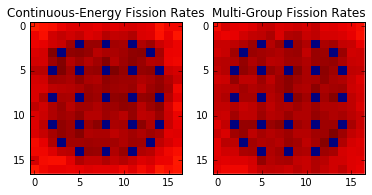

In [41]:
# Plot the CE fission rates in the left subplot
fig = plt.subplot(121)
plt.imshow(openmc_fission_rates, interpolation='none', cmap='jet')
plt.title('Continuous-Energy Fission Rates')

# Plot the MG fission rates in the right subplot
fig2 = plt.subplot(122)
plt.imshow(mgopenmc_fission_rates, interpolation='none', cmap='jet')
plt.title('Multi-Group Fission Rates')


We also see very good agreement between the fission rate distributions.